# SmallPebble

[![](https://github.com/sradc/smallpebble/workflows/Python%20package/badge.svg)](https://github.com/sradc/smallpebble/commits/) 

**Project status: unstable.**

<br><p align="center"><img src="https://raw.githubusercontent.com/sradc/SmallPebble/master/pebbles.jpg"/></p><br>

SmallPebble is a minimal automatic differentiation and deep learning library written from scratch in [Python](https://www.python.org/), using [NumPy](https://numpy.org/)/[CuPy](https://cupy.dev/).

The implementation is relatively small, and mainly in the file: [smallpebble.py](https://github.com/sradc/SmallPebble/blob/master/smallpebble/smallpebble.py). To help understand it, check out [this](https://sidsite.com/posts/autodiff/) introduction to autodiff, which presents an autodiff framework that works in the same way as SmallPebble (except using scalars instead of NumPy arrays).

SmallPebble's *raison d'etre* is to be a simplified deep learning implementation,
for those who want to learn what’s under the hood of deep learning frameworks.
However, because it is written in terms of vectorised NumPy/CuPy operations,
it performs well enough for non-trivial models to be trained using it.

**Highlights**
- Relatively simple implementation.
- Can run on GPU, using CuPy.
- Various operations, such as matmul, conv2d, maxpool2d.
- Array broadcasting support.
- Eager or lazy execution.
- Powerful API for creating models.
- It's easy to add new SmallPebble functions.


**Notes**

Graphs are built implicitly via Python objects referencing Python objects.
When `get_gradients` is called, autodiff is carried out on the whole sub-graph. The default array library is NumPy.

---

**Read on to see:**
- Example models created and trained using SmallPebble.
- A brief guide to using SmallPebble.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import smallpebble as sp
from smallpebble.misc import load_data

## Training a neural network to classify handwritten digits (MNIST)

In [2]:
"Load the dataset, and create a validation set."

X_train, y_train, _, _ = load_data('mnist')  # load / download from openml.org
X_train = X_train/255  # normalize

# Seperate out data for validation.
X = X_train[:50_000, ...]
y = y_train[:50_000]
X_eval = X_train[50_000:60_000, ...]
y_eval = y_train[50_000:60_000]

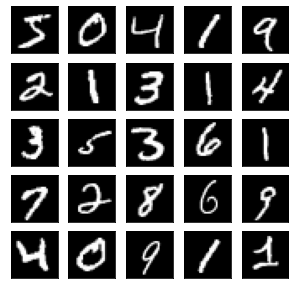

In [3]:
"Plot, to check we have the right data."

plt.figure(figsize=(5,5))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i,:].reshape(28,28), cmap='gray', vmin=0, vmax=1)

plt.show()

In [4]:
"Create a model, with two fully connected hidden layers."

X_in = sp.Placeholder()
y_true = sp.Placeholder()

h = sp.linearlayer(28*28, 100)(X_in)
h = sp.Lazy(sp.leaky_relu)(h)
h = sp.linearlayer(100, 100)(h)
h = sp.Lazy(sp.leaky_relu)(h)
h = sp.linearlayer(100, 10)(h)
y_pred = sp.Lazy(sp.softmax)(h)
loss = sp.Lazy(sp.cross_entropy)(y_pred, y_true)

learnables = sp.get_learnables(y_pred)

loss_vals = []
validation_acc = []

Final validation accuracy: 0.935


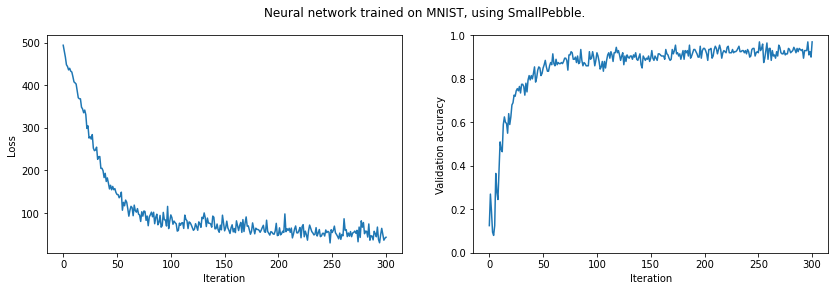

In [5]:
"Train model, while measuring performance on the validation dataset."

NUM_ITERS = 300
BATCH_SIZE = 200

eval_batch = sp.batch(X_eval, y_eval, BATCH_SIZE)
adam = sp.Adam()  # Adam optimization

for i, (xbatch, ybatch) in tqdm(enumerate(sp.batch(X, y, BATCH_SIZE)), total=NUM_EPOCHS):
    if i >= NUM_ITERS: break
    
    X_in.assign_value(sp.Variable(xbatch))
    y_true.assign_value(ybatch)
    
    loss_val = loss.run()  # run the graph
    if np.isnan(loss_val.array):
        print("loss is nan, aborting.")
        break
    loss_vals.append(loss_val.array)
        
    # Compute gradients, and use to carry out learning step:
    gradients = sp.get_gradients(loss_val)
    adam.training_step(learnables, gradients)
        
    # Compute validation accuracy:
    x_eval_batch, y_eval_batch = next(eval_batch)
    X_in.assign_value(sp.Variable(x_eval_batch))
    predictions = y_pred.run()
    predictions = np.argmax(predictions.array, axis=1)
    accuracy = (y_eval_batch == predictions).mean()
    validation_acc.append(accuracy)

# Plot results:
print(f'Final validation accuracy: {validation_acc[-10].mean()}')
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.plot(loss_vals)
plt.subplot(1, 2, 2)
plt.ylabel('Validation accuracy')
plt.xlabel('Iteration')
plt.suptitle('Neural network trained on MNIST, using SmallPebble.')
plt.ylim([0, 1])
plt.plot(validation_acc)
plt.show()

## Training a convolutional neural network on CIFAR-10, using CuPy
This was run on [Google Colab](https://colab.research.google.com/), with a GPU.

In [22]:
"Load the CIFAR dataset."

X_train, y_train, _, _ = load_data('cifar')  # load/download from openml.org
X_train = X_train/255  # normalize

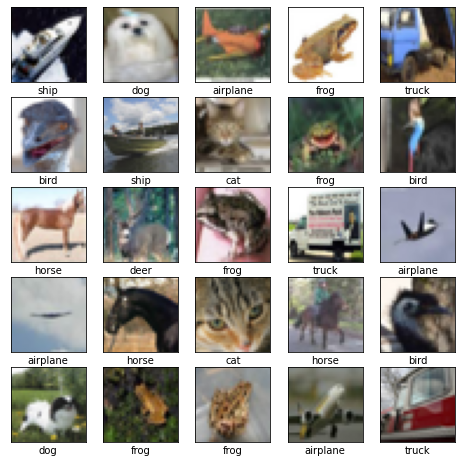

In [23]:
"""Plot, to check it's the right data.

(This cell's code is from: https://www.tensorflow.org/tutorials/images/cnn#verify_the_data)
"""

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(8,8))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i,:].reshape(32,32,3))
    plt.xlabel(class_names[y_train[i]])

plt.show()

In [24]:
"Switch array library to CuPy, so can use GPU."

import cupy

sp.use(cupy)

print(sp.array_library.library.__name__)  # should be 'cupy'

cupy


In [25]:
"Convert data to CuPy arrays"

X_train = cupy.array(X_train)
y_train = cupy.array(y_train)

# Seperate out data for validation as before.
X = X_train[:45_000, ...]
y = y_train[:45_000]
X_eval = X_train[45_000:50_000, ...]
y_eval = y_train[45_000:50_000]

In [42]:
"Define a model."

X_in = sp.Placeholder()
y_true = sp.Placeholder()

h = sp.convlayer(height=3, width=3, depth=3, n_kernels=32)(X_in)
h = sp.Lazy(sp.leaky_relu)(h)
h = sp.Lazy(lambda a: sp.maxpool2d(a, 2, 2, strides=[2, 2]))(h)

h = sp.convlayer(3, 3, 32, 128, padding='VALID')(h)
h = sp.Lazy(sp.leaky_relu)(h)
h = sp.Lazy(lambda a: sp.maxpool2d(a, 2, 2, strides=[2, 2]))(h)

h = sp.convlayer(3, 3, 128, 128, padding='VALID')(h)
h = sp.Lazy(sp.leaky_relu)(h)
h = sp.Lazy(lambda a: sp.maxpool2d(a, 2, 2, strides=[2, 2]))(h)

h = sp.Lazy(lambda x: sp.reshape(x, [-1, 3*3*128]))(h)
h = sp.linearlayer(3*3*128, 10)(h)
h = sp.Lazy(sp.softmax)(h)

y_pred = h
loss = sp.Lazy(sp.cross_entropy)(y_pred, y_true)

learnables = sp.get_learnables(y_pred)

loss_vals = []
validation_acc = []

# Check we get the expected dimensions
X_in.assign_value(sp.Variable(X[0:3, :].reshape([-1, 32, 32, 3])))
h.run().shape

(3, 10)

Train the model.

Final validation accuracy: 0.6640625


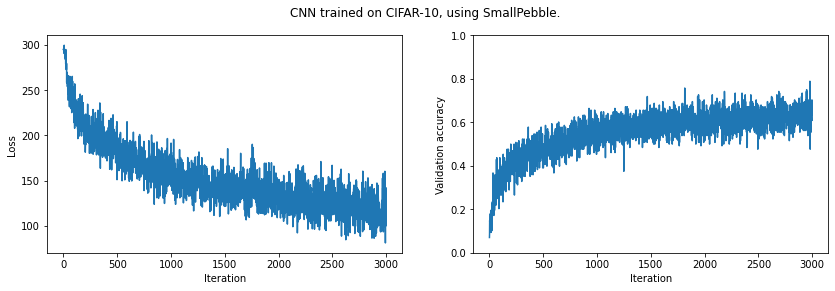

In [43]:
NUM_ITERS = 3000
BATCH_SIZE = 128

eval_batch = sp.batch(X_eval, y_eval, BATCH_SIZE)
adam = sp.Adam()

for i, (xbatch, ybatch) in tqdm(enumerate(sp.batch(X, y, BATCH_SIZE)), total=NUM_EPOCHS):
    if i >= NUM_ITERS: break
       
    xbatch_images = xbatch.reshape([-1, 32, 32, 3])
    X_in.assign_value(sp.Variable(xbatch_images))
    y_true.assign_value(ybatch)
    
    loss_val = loss.run()
    if np.isnan(loss_val.array):
        print("Aborting, loss is nan.")
        break
    loss_vals.append(loss_val.array)
    
    # Compute gradients, and carry out learning step.
    gradients = sp.get_gradients(loss_val)  
    adam.training_step(learnables, gradients)
    
    # Compute validation accuracy:
    x_eval_batch, y_eval_batch = next(eval_batch)
    X_in.assign_value(sp.Variable(x_eval_batch.reshape([-1, 32, 32, 3])))
    predictions = y_pred.run()
    predictions = np.argmax(predictions.array, axis=1)
    accuracy = (y_eval_batch == predictions).mean()
    validation_acc.append(accuracy)

print(f'Final validation accuracy: {validation_acc[-10].mean()}')
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.plot(loss_vals)
plt.subplot(1, 2, 2)
plt.ylabel('Validation accuracy')
plt.xlabel('Iteration')
plt.suptitle('CNN trained on CIFAR-10, using SmallPebble.')
plt.ylim([0, 1])
plt.plot(validation_acc)
plt.show()

It looks like we could improve our results by training for longer (and of course we could improve our model architecture).

---

# Brief guide to using SmallPebble

SmallPebble provides the following building blocks to make models with:

- `sp.Variable`
- Operations, such as `sp.add`, `sp.mul`, etc.
- `sp.get_gradients`
- `sp.Lazy`
- `sp.Placeholder` (this is really just `sp.Lazy` on the identity function)
- `sp.learnable`
- `sp.get_learnables`

The following examples show how these are used.


## Switching between NumPy and CuPy

We can dynamically switch between NumPy and CuPy. (Assuming you have a CuPy compatible GPU and CuPy set up. Note, CuPy is available on Google Colab, if you change the runtime to GPU.)

In [12]:
import cupy
import numpy
import smallpebble as sp
 
# Switch to CuPy
sp.use(cupy)
print(sp.array_library.library.__name__)  # should be 'cupy'

# Switch back to NumPy:
sp.use(numpy)
print(sp.array_library.library.__name__)  # should be 'numpy'

cupy
numpy


## sp.Variable & sp.get_gradients 

With SmallPebble, you can:

- Wrap NumPy arrays in `sp.Variable`
- Apply SmallPebble operations (e.g. `sp.matmul`, `sp.add`, etc.)
- Compute gradients with `sp.get_gradients`

In [13]:
a = sp.Variable(np.random.random([2, 2]))
b = sp.Variable(np.random.random([2, 2]))
c = sp.Variable(np.random.random([2]))
y = sp.mul(a, b) + c
print('y.array:\n', y.array)

gradients = sp.get_gradients(y)
grad_a = gradients[a]
grad_b = gradients[b]
grad_c = gradients[c]
print('grad_a:\n', grad_a)
print('grad_b:\n', grad_b)
print('grad_c:\n', grad_c)

y.array:
 [[0.83571629 1.04060209]
 [0.83590755 0.76613642]]
grad_a:
 [[0.29385811 0.41138988]
 [0.28457185 0.00655705]]
grad_b:
 [[0.15671755 0.67454729]
 [0.16250373 0.46305269]]
grad_c:
 [2. 2.]


Note that `y` is computed straight away, i.e. the (forward) computation happens immediately.

Also note that `y` is a sp.Variable and we could continue to carry out SmallPebble operations on it.

## sp.Lazy & sp.Placeholder

Lazy graphs are constructed using `sp.Lazy` and `sp.Placeholder`. 

In [14]:
lazy_node = sp.Lazy(lambda a, b: a + b)(1, 2)
print(lazy_node)
print(lazy_node.run())

3


In [15]:
a = sp.Lazy(lambda a: a)(2)
y = sp.Lazy(lambda a, b, c: a * b + c)(a, 3, 4)
print(y)
print(y.run())

10


Forward computation does not happen immediately - only when .run() is called.

In [16]:
a = sp.Placeholder()
b = sp.Variable(np.random.random([2, 2]))
y = sp.Lazy(sp.matmul)(a, b)

a.assign_value(sp.Variable(np.array([[1,2], [3,4]])))

result = y.run()
print('result.array:\n', result.array)

result.array:
 [[0.85771129 1.28521573]
 [1.95373653 2.6991665 ]]


You can use .run() as many times as you like. 

Let's change the placeholder value and re-run the graph:

In [17]:
a.assign_value(sp.Variable(np.array([[10,20], [30,40]])))
result = y.run()
print('result.array:\n', result.array)

result.array:
 [[ 8.57711288 12.85215729]
 [19.53736528 26.99166502]]


Finally, let's compute gradients:

In [18]:
gradients = sp.get_gradients(result)

Note that `sp.get_gradients` is called on `result`, 
which is a `sp.Variable`, 
not on `y`, which is a `sp.Lazy` instance.

## sp.learnable & sp.get_learnables
Use `sp.learnable` to flag parameters as learnable, 
allowing them to be extracted from a lazy graph with `sp.get_learnables`.

This enables a workflow of: building a model, while flagging parameters as learnable, and then extracting all the parameters in one go at the end.


In [19]:
a = sp.Placeholder()
b = sp.learnable(sp.Variable(np.random.random([2, 1])))
y = sp.Lazy(sp.matmul)(a, b)
y = sp.Lazy(sp.add)(y, sp.learnable(sp.Variable(np.array([5]))))

learnables = sp.get_learnables(y)

for learnable in learnables:
    print(learnable)